

# Signal-space separation (SSS) and Maxwell filtering

This tutorial covers reducing environmental noise and compensating for head
movement with SSS and Maxwell filtering.

As usual, we'll start by importing the modules we need, loading some
`example data <sample-dataset>`, and cropping it to save on memory:


In [1]:
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import mne
from mne.preprocessing import find_bad_channels_maxwell

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False)
raw.crop(tmax=60)

Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus, 59 EEG, 1 EOG"
Bad channels,"MEG 2443, EEG 053"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


## Background on SSS and Maxwell filtering

Signal-space separation (SSS) :footcite:`TauluKajola2005,TauluSimola2006`
is a technique based on the physics
of electromagnetic fields. SSS separates the measured signal into components
attributable to sources *inside* the measurement volume of the sensor array
(the *internal components*), and components attributable to sources *outside*
the measurement volume (the *external components*). The internal and external
components are linearly independent, so it is possible to simply discard the
external components to reduce environmental noise. *Maxwell filtering* is a
related procedure that omits the higher-order components of the internal
subspace, which are dominated by sensor noise. Typically, Maxwell filtering
and SSS are performed together (in MNE-Python they are implemented together
in a single function).

Like `SSP <tut-artifact-ssp>`, SSS is a form of projection. Whereas SSP
empirically determines a noise subspace based on data (empty-room recordings,
EOG or ECG activity, etc) and projects the measurements onto a subspace
orthogonal to the noise, SSS mathematically constructs the external and
internal subspaces from `spherical harmonics`_ and reconstructs the sensor
signals using only the internal subspace (i.e., does an oblique projection).

<div class="alert alert-danger"><h4>Warning</h4><p>Maxwell filtering was originally developed for Elekta Neuromag® systems,
    and should be considered *experimental* for non-Neuromag data. See the
    Notes section of the :func:`~mne.preprocessing.maxwell_filter` docstring
    for details.</p></div>

The MNE-Python implementation of SSS / Maxwell filtering currently provides
the following features:

- Basic bad channel detection
  (:func:`~mne.preprocessing.find_bad_channels_maxwell`)
- Bad channel reconstruction
- Cross-talk cancellation
- Fine calibration correction
- tSSS
- Coordinate frame translation
- Regularization of internal components using information theory
- Raw movement compensation (using head positions estimated by MaxFilter)
- cHPI subtraction (see :func:`mne.chpi.filter_chpi`)
- Handling of 3D (in addition to 1D) fine calibration files
- Epoch-based movement compensation as described in
  :footcite:`TauluKajola2005` through :func:`mne.epochs.average_movements`
- **Experimental** processing of data from (un-compensated) non-Elekta
  systems


## Using SSS and Maxwell filtering in MNE-Python

For optimal use of SSS with data from Elekta Neuromag® systems, you should
provide the path to the fine calibration file (which encodes site-specific
information about sensor orientation and calibration) as well as a crosstalk
compensation file (which reduces interference between Elekta's co-located
magnetometer and paired gradiometer sensor units).



In [3]:
fine_cal_file = os.path.join(sample_data_folder, "SSS", "sss_cal_mgh.dat")
crosstalk_file = os.path.join(sample_data_folder, "SSS", "ct_sparse_mgh.fif")

Before we perform SSS we'll look for bad channels — ``MEG 2443`` is quite
noisy.

<div class="alert alert-danger"><h4>Warning</h4><p>It is critical to mark bad channels in ``raw.info['bads']`` *before*
    calling :func:`~mne.preprocessing.maxwell_filter` in order to prevent
    bad channel noise from spreading.</p></div>

Let's see if we can automatically detect it.



In [4]:
raw.info["bads"] = []
raw_check = raw.copy()
auto_noisy_chs, auto_flat_chs, auto_scores = find_bad_channels_maxwell(
    raw_check,
    cross_talk=crosstalk_file,
    calibration=fine_cal_file,
    return_scores=True,
    verbose=True,
)
print(auto_noisy_chs)  # we should find them!
print(auto_flat_chs)  # none for this dataset

Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 36037  =      0.000 ...    60.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 199 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


Scanning for bad channels in 12 intervals (5.0 s) ...
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s


    Using fine calibration sss_cal_mgh.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.5° ± 0.4° (max: 2.1°)
    Automatic origin fit: head of radius 91.0 mm
    Using origin -4.1, 16.0, 51.8 mm in the head frame
        Interval   1:    0.000 -    4.998
        Interval   2:    5.000 -    9.998
        Interval   3:   10.000 -   14.998
        Interval   4:   15.000 -   19.998
        Interval   5:   20.000 -   24.998
        Interval   6:   24.999 -   29.998
        Interval   7:   29.999 -   34.997
        Interval   8:   34.999 -   39.997
        Interval   9:   39.999 -   44.997
        Interval  10:   44.999 -   49.997
        Interval  11:   49.999 -   54.997
        Interval  12:   54.999 -   60.000
    Static bad channels:  ['MEG 2443']
    Static flat channels: []
[done]
['MEG 2443']
[]


<div class="alert alert-info"><h4>Note</h4><p>`~mne.preprocessing.find_bad_channels_maxwell` needs to operate on
          a signal without line noise or cHPI signals. By default, it simply
          applies a low-pass filter with a cutoff frequency of 40 Hz to the
          data, which should remove these artifacts. You may also specify a
          different cutoff by passing the ``h_freq`` keyword argument. If you
          set ``h_freq=None``, no filtering will be applied. This can be
          useful if your data has already been preconditioned, for example
          using :func:`mne.chpi.filter_chpi`,
          :func:`mne.io.Raw.notch_filter`, or :meth:`mne.io.Raw.filter`.</p></div>

Now we can update the list of bad channels in the dataset.



In [5]:
bads = raw.info["bads"] + auto_noisy_chs + auto_flat_chs
raw.info["bads"] = bads

We called `~mne.preprocessing.find_bad_channels_maxwell` with the optional
keyword argument ``return_scores=True``, causing the function to return a
dictionary of all data related to the scoring used to classify channels as
noisy or flat. This information can be used to produce diagnostic figures.

In the following, we will generate such visualizations for
the automated detection of *noisy* gradiometer channels.



Text(0.5, 1.0, 'Scores > Limit')

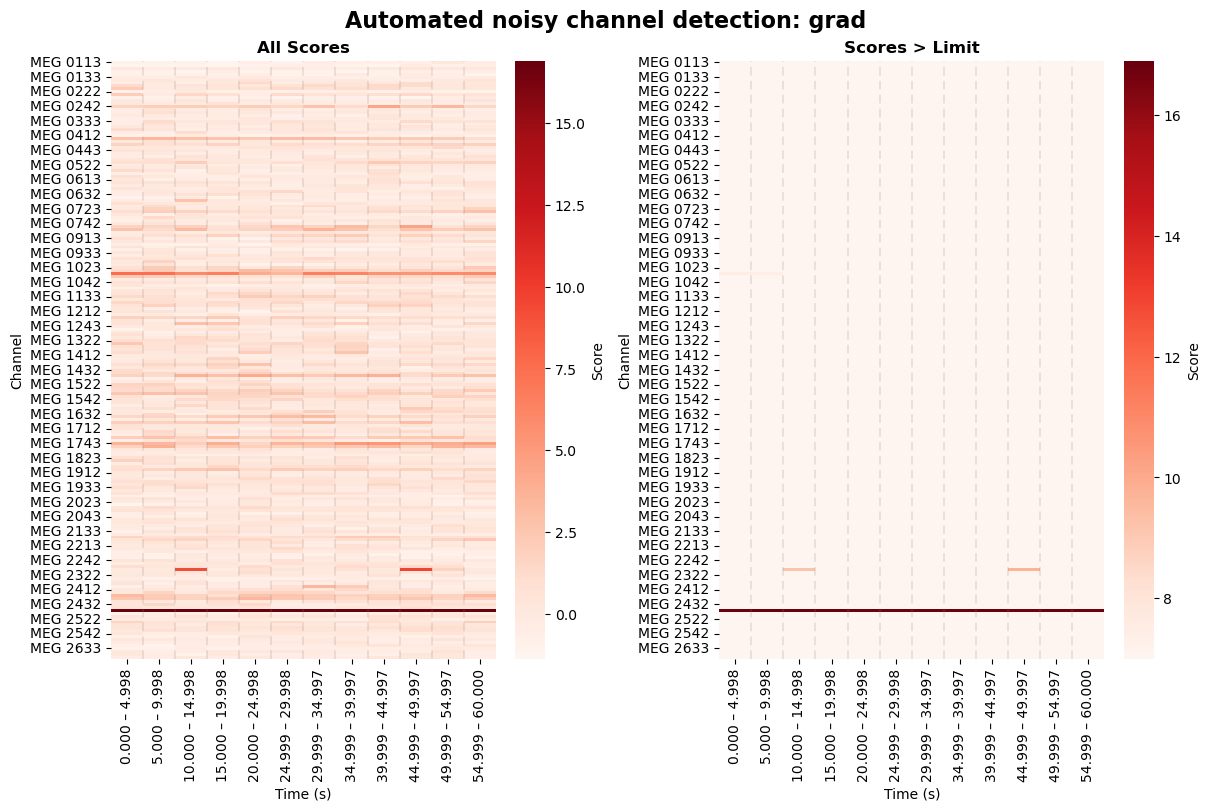

In [6]:
# Only select the data for gradiometer channels.
ch_type = "grad"
ch_subset = auto_scores["ch_types"] == ch_type
ch_names = auto_scores["ch_names"][ch_subset]
scores = auto_scores["scores_noisy"][ch_subset]
limits = auto_scores["limits_noisy"][ch_subset]
bins = auto_scores["bins"]  # The the windows that were evaluated.
# We will label each segment by its start and stop time, with up to 3
# digits before and 3 digits after the decimal place (1 ms precision).
bin_labels = [f"{start:3.3f} – {stop:3.3f}" for start, stop in bins]

# We store the data in a Pandas DataFrame. The seaborn heatmap function
# we will call below will then be able to automatically assign the correct
# labels to all axes.
data_to_plot = pd.DataFrame(
    data=scores,
    columns=pd.Index(bin_labels, name="Time (s)"),
    index=pd.Index(ch_names, name="Channel"),
)

# First, plot the "raw" scores.
fig, ax = plt.subplots(1, 2, figsize=(12, 8), layout="constrained")
fig.suptitle(
    f"Automated noisy channel detection: {ch_type}", fontsize=16, fontweight="bold"
)
sns.heatmap(data=data_to_plot, cmap="Reds", cbar_kws=dict(label="Score"), ax=ax[0])
[
    ax[0].axvline(x, ls="dashed", lw=0.25, dashes=(25, 15), color="gray")
    for x in range(1, len(bins))
]
ax[0].set_title("All Scores", fontweight="bold")

# Now, adjust the color range to highlight segments that exceeded the limit.
sns.heatmap(
    data=data_to_plot,
    vmin=np.nanmin(limits),  # bads in input data have NaN limits
    cmap="Reds",
    cbar_kws=dict(label="Score"),
    ax=ax[1],
)
[
    ax[1].axvline(x, ls="dashed", lw=0.25, dashes=(25, 15), color="gray")
    for x in range(1, len(bins))
]
ax[1].set_title("Scores > Limit", fontweight="bold")

<div class="alert alert-info"><h4>Note</h4><p>You can use the very same code as above to produce figures for
          *flat* channel detection. Simply replace the word "noisy" with
          "flat", and replace ``vmin=np.nanmin(limits)`` with
          ``vmax=np.nanmax(limits)``.</p></div>

You can see the un-altered scores for each channel and time segment in the
left subplots, and thresholded scores – those which exceeded a certain limit
of noisiness – in the right subplots. While the right subplot is entirely
white for the magnetometers, we can see a horizontal line extending all the
way from left to right for the gradiometers. This line corresponds to channel
``MEG 2443``, which was reported as auto-detected noisy channel in the step
above. But we can also see another channel exceeding the limits, apparently
in a more transient fashion. It was therefore *not* detected as bad, because
the number of segments in which it exceeded the limits was less than 5,
which MNE-Python uses by default.

<div class="alert alert-info"><h4>Note</h4><p>You can request a different number of segments that must be
          found to be problematic before
          `~mne.preprocessing.find_bad_channels_maxwell` reports them as bad.
          To do this, pass the keyword argument ``min_count`` to the
          function.</p></div>



Obviously, this algorithm is not perfect. Specifically, on closer inspection
of the raw data after looking at the diagnostic plots above, it becomes clear
that the channel exceeding the "noise" limits in some segments without
qualifying as "bad", in fact contains some flux jumps. There were just not
*enough* flux jumps in the recording for our automated procedure to report
the channel as bad. So it can still be useful to manually inspect and mark
bad channels. The channel in question is ``MEG 2313``. Let's mark it as bad:



In [7]:
raw.info["bads"] += ["MEG 2313"]  # from manual inspection

After that, performing SSS and Maxwell filtering is done with a
single call to :func:`~mne.preprocessing.maxwell_filter`, with the crosstalk
and fine calibration filenames provided (if available):



In [8]:
raw_sss = mne.preprocessing.maxwell_filter(
    raw, cross_talk=crosstalk_file, calibration=fine_cal_file, verbose=True
)

Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG 2443', 'MEG 2313']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal_mgh.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.5° ± 0.4° (max: 2.1°)
    Automatic origin fit: head of radius 91.0 mm
    Using origin -4.1, 16.0, 51.8 mm in the head frame
        Using 87/95 harmonic components for    0.000  (72/80 in, 15/15 out)
    Loading raw data from disk
    Processing 6 data chunks
[done]


To see the effect, we can plot the data before and after SSS / Maxwell
filtering.



In [9]:
raw.pick(["meg"]).plot(duration=2, butterfly=True)
raw_sss.pick(["meg"]).plot(duration=2, butterfly=True)

Using qt as 2D backend.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-olaf'


Notice that channels marked as "bad" have been effectively repaired by SSS,
eliminating the need to perform `interpolation <tut-bad-channels>`.
The heartbeat artifact has also been substantially reduced.

The :func:`~mne.preprocessing.maxwell_filter` function has parameters
``int_order`` and ``ext_order`` for setting the order of the spherical
harmonic expansion of the interior and exterior components; the default
values are appropriate for most use cases. Additional parameters include
``coord_frame`` and ``origin`` for controlling the coordinate frame ("head"
or "meg") and the origin of the sphere; the defaults are appropriate for most
studies that include digitization of the scalp surface / electrodes. See the
documentation of :func:`~mne.preprocessing.maxwell_filter` for details.


## Spatiotemporal SSS (tSSS)

An assumption of SSS is that the measurement volume (the spherical shell
where the sensors are physically located) is free of electromagnetic sources.
The thickness of this source-free measurement shell should be 4-8 cm for SSS
to perform optimally. In practice, there may be sources falling within that
measurement volume; these can often be mitigated by using Spatiotemporal
Signal Space Separation (tSSS) :footcite:`TauluSimola2006`.
tSSS works by looking for temporal
correlation between components of the internal and external subspaces, and
projecting out any components that are common to the internal and external
subspaces. The projection is done in an analogous way to
`SSP <tut-artifact-ssp>`, except that the noise vector is computed
across time points instead of across sensors.

To use tSSS in MNE-Python, pass a time (in seconds) to the parameter
``st_duration`` of :func:`~mne.preprocessing.maxwell_filter`. This will
determine the "chunk duration" over which to compute the temporal projection.
The chunk duration effectively acts as a high-pass filter with a cutoff
frequency of $\frac{1}{\mathtt{st\_duration}}~\mathrm{Hz}$; this
effective high-pass has an important consequence:

- In general, larger values of ``st_duration`` are better (provided that your
  computer has sufficient memory) because larger values of ``st_duration``
  will have a smaller effect on the signal.

If the chunk duration does not evenly divide your data length, the final
(shorter) chunk will be added to the prior chunk before filtering, leading
to slightly different effective filtering for the combined chunk (the
effective cutoff frequency differing at most by a factor of 2). If you need
to ensure identical processing of all analyzed chunks, either:

- choose a chunk duration that evenly divides your data length (only
  recommended if analyzing a single subject or run), or

- include at least ``2 * st_duration`` of post-experiment recording time at
  the end of the :class:`~mne.io.Raw` object, so that the data you intend to
  further analyze is guaranteed not to be in the final or penultimate chunks.

Additional parameters affecting tSSS include ``st_correlation`` (to set the
correlation value above which correlated internal and external components
will be projected out) and ``st_only`` (to apply only the temporal projection
without also performing SSS and Maxwell filtering). See the docstring of
:func:`~mne.preprocessing.maxwell_filter` for details.


## Movement compensation

If you have information about subject head position relative to the sensors
(i.e., continuous head position indicator coils, or :term:`cHPI`), SSS
can take that into account when projecting sensor data onto the internal
subspace. In case you are not sure whether you have that information or
want to doublecheck, you can use :func:`mne.chpi.get_active_chpi` (currently
only implemented for neuromag systems).



In [10]:
chpi_fif_file = os.path.join(
    mne.datasets.testing.data_path(), "SSS", "test_move_anon_raw.fif"
)
raw = mne.io.read_raw_fif(chpi_fif_file, allow_maxshield="yes")

# time-resolved information on active HPI coils
# if all hpi were inactive n_active is a zero-array
n_active = mne.chpi.get_active_chpi(raw)
print(f"Average number of coils active during recording: {n_active.mean()}")

Opening raw data file /imaging/local/software/mne_python/vdevel/examples/MNE-testing-data/SSS/test_move_anon_raw.fif...
    Read a total of 12 projection items:
        mag.fif : PCA-v1 (1 x 306)  idle
        mag.fif : PCA-v2 (1 x 306)  idle
        mag.fif : PCA-v3 (1 x 306)  idle
        mag.fif : PCA-v4 (1 x 306)  idle
        mag.fif : PCA-v5 (1 x 306)  idle
        mag.fif : PCA-v6 (1 x 306)  idle
        mag.fif : PCA-v7 (1 x 306)  idle
        grad.fif : PCA-v1 (1 x 306)  idle
        grad.fif : PCA-v2 (1 x 306)  idle
        grad.fif : PCA-v3 (1 x 306)  idle
        grad.fif : PCA-v4 (1 x 306)  idle
        Average EEG reference (1 x 60)  idle
    Range : 10800 ... 31199 =      9.000 ...    25.999 secs
Ready.
Using 5 HPI coils: 83 143 203 263 323 Hz
Average number of coils active during recording: 5.0


Head position data can be computed using
:func:`mne.chpi.compute_chpi_locs` and :func:`mne.chpi.compute_head_pos`,
or loaded with the :func:`mne.chpi.read_head_pos` function. The
`example data <sample-dataset>` doesn't include cHPI, so here we'll
load a :file:`.pos` file used for testing, just to demonstrate:



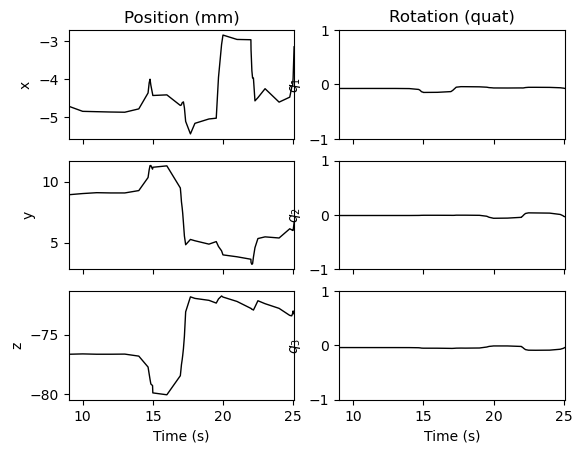

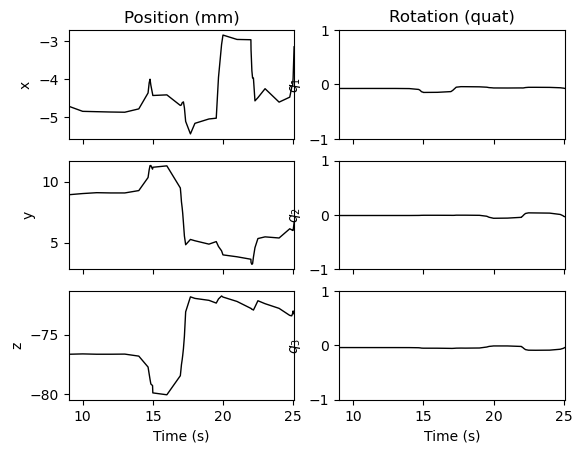

In [11]:
head_pos_file = os.path.join(
    mne.datasets.testing.data_path(), "SSS", "test_move_anon_raw.pos"
)
head_pos = mne.chpi.read_head_pos(head_pos_file)
mne.viz.plot_head_positions(head_pos, mode="traces")

The cHPI data file could also be passed as the ``head_pos`` parameter of
:func:`~mne.preprocessing.maxwell_filter`. Not only would this account for
movement within a given recording session, but also would effectively
normalize head position across different measurement sessions and subjects.
See `here <ex-movement-comp>` for an extended example of applying
movement compensation during Maxwell filtering / SSS. Another option is to
apply movement compensation when averaging epochs into an
:class:`~mne.Evoked` instance, using the :func:`mne.epochs.average_movements`
function.

Each of these approaches requires time-varying estimates of head position,
which is obtained from MaxFilter using the ``-headpos`` and ``-hp``
arguments (see the MaxFilter manual for details).


## Caveats to using SSS / Maxwell filtering

1. There are patents related to the Maxwell filtering algorithm, which may
   legally preclude using it in commercial applications. More details are
   provided in the documentation of
   :func:`~mne.preprocessing.maxwell_filter`.

2. SSS works best when both magnetometers and gradiometers are present, and
   is most effective when gradiometers are planar (due to the need for very
   accurate sensor geometry and fine calibration information). Thus its
   performance is dependent on the MEG system used to collect the data.


## References

.. footbibliography::


.. LINKS


